## I. Import Lib dependences


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
InteractiveShell.display_truncate_limit = 20  #

In [2]:
from config import *
from data.reader import read_documents, read_queries, read_relevance
from data.preprocessor import preprocess_documents,create_inverted_index,compute_idf_vector,preprocess_text
from models.boolean import boolean_retrieval
from evaluation.plot import plot_precision_recall,compute_interpolated_precisions,plot_interpolated_map,evaluate_precision_recall
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import Counter,OrderedDict
import re
from wordcloud import WordCloud
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.preprocessing import normalize


In [3]:
## Read data

documents = read_documents(DOCUMENTS_PATH)
queries = read_queries(QUERIES_PATH)
relevance = read_relevance(RELEVANCE_PATH)

Reading documents from: in/Cranfield\Cranfield_data


## II. Data Overview


### Data Overview

In [4]:
def print_documents_overview(documents, top_k=10,name="Documents"):
    num_docs = len(documents)
    lengths = [len(re.findall(r"\w+", doc)) for doc in documents]
    all_words = []

    for doc in documents:
        words = re.findall(r"\w+", doc.lower())
        all_words.extend(words)

    word_counts = Counter(all_words)
    top_words = word_counts.most_common(top_k)

    print(f"📄{name} Overview:")
    print(f"- Number of {name}: {num_docs}")
    print(f"- Sum of word: {sum(lengths)}")
    print(f"- Average word for each {name}: {np.mean(lengths):.2f}")
    print(f"- Shortest {name}: {min(lengths)} word")
    print(f"- Longest {name}: {max(lengths)} word")
    print(f"- Top {top_k} popular word:")
    for word, count in top_words:
        print(f"    {word}: {count} times")

print_documents_overview(documents)

📄Documents Overview:
- Number of Documents: 1400
- Sum of word: 226673
- Average word for each Documents: 161.91
- Shortest Documents: 0 word
- Longest Documents: 662 word
- Top 10 popular word:
    the: 19444 times
    of: 12671 times
    and: 6149 times
    a: 5913 times
    in: 4642 times
    to: 4566 times
    is: 4114 times
    for: 3489 times
    are: 2429 times
    with: 2263 times


In [5]:
print_documents_overview(queries,name="Queries")

📄Queries Overview:
- Number of Queries: 225
- Sum of word: 3907
- Average word for each Queries: 17.36
- Shortest Queries: 5 word
- Longest Queries: 44 word
- Top 10 popular word:
    the: 249 times
    of: 205 times
    a: 112 times
    in: 88 times
    what: 85 times
    on: 79 times
    to: 63 times
    is: 61 times
    for: 56 times
    flow: 49 times


In [6]:
for i in range(len(relevance)):
    print(f"Query {i+1} relevance: {relevance[i+1]}")

Query 1 relevance: [184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880, 486]
Query 2 relevance: [12, 15, 184, 858, 51, 102, 202, 14, 52, 380, 746, 859, 948, 285, 390, 391, 442, 497, 643, 856, 857, 877, 864, 658, 486]
Query 3 relevance: [5, 6, 90, 91, 119, 144, 181, 399, 485]
Query 4 relevance: [236, 166, 488]
Query 5 relevance: [552, 401, 1297, 1296, 488]
Query 6 relevance: [99, 115, 257, 258, 491]
Query 7 relevance: [20, 56, 57, 58, 19, 492]
Query 8 relevance: [48, 122, 20, 58, 196, 354, 360, 197, 999, 1112, 1005, 492]
Query 9 relevance: [21, 22, 550, 534]
Query 10 relevance: [259, 405, 302, 436, 437, 438, 998, 1011, 493]
Query 11 relevance: [27, 28, 262, 160, 20, 263, 654, 495]
Query 12 relevance: [86, 194, 650, 649, 652, 624]
Query 13 relevance: [64, 265, 65, 311, 496]
Query 14 relevance: [64, 65, 496]
Query 15 relevance: [463, 462, 497]
Query 16 relevance: [266, 106, 196, 498]
Query 17 relevance: [106, 196, 4

## III. Document Preprocessing  

#### Create Vocabulary and Process Documents

In [7]:
processed_docs,vocab_lst = preprocess_documents(documents)

In [8]:
for i, doc in enumerate(processed_docs):
    if len(doc) == 0:
        print(f"Document {i} is empty after preprocessing.")
        processed_docs[i] = []

Document 470 is empty after preprocessing.
Document 994 is empty after preprocessing.


##### Vocabulary

In [9]:
print(vocab_lst)
print(len(vocab_lst))

['000degre', '000degreek', '000k', '0degre', '100degre', '100x10', '10degre', '10g', '1103a', '11in', '12degre', '1400degreek', '14in', '14x10', '15degre', '15x10', '15x106', '180degre', '18degre', '18in', '195e', '1degre', '1x10', '200degre', '20degre', '20degreec', '24s', '25degre', '25x10', '2x10', '3000degreek', '300degreer', '30degre', '30th', '3600degreek', '3ft', '3x10', '400degre', '40degre', '45degre', '49degre', '4degre', '4ft', '4th', '4x10', '500degre', '50degre', '55degre', '5degre', '5th', '6000degreek', '60degre', '63a2xx', '63a4xx', '64a010', '65a004', '65degre', '6in', '6x10', '700f', '707a', '75degre', '75s', '800degre', '85degre', '8x10', '90degre', '99degre', '9x10', 'a50f06', 'a51j04', 'a52b06', 'abbrevi', 'abil', 'abl', 'ablat', 'abrupt', 'absenc', 'absent', 'absolut', 'absorb', 'absorpt', 'abstract', 'abund', 'academ', 'acceler', 'acceleromet', 'accentu', 'accept', 'access', 'accident', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accru', 'accumul

### Wordcloud visualize

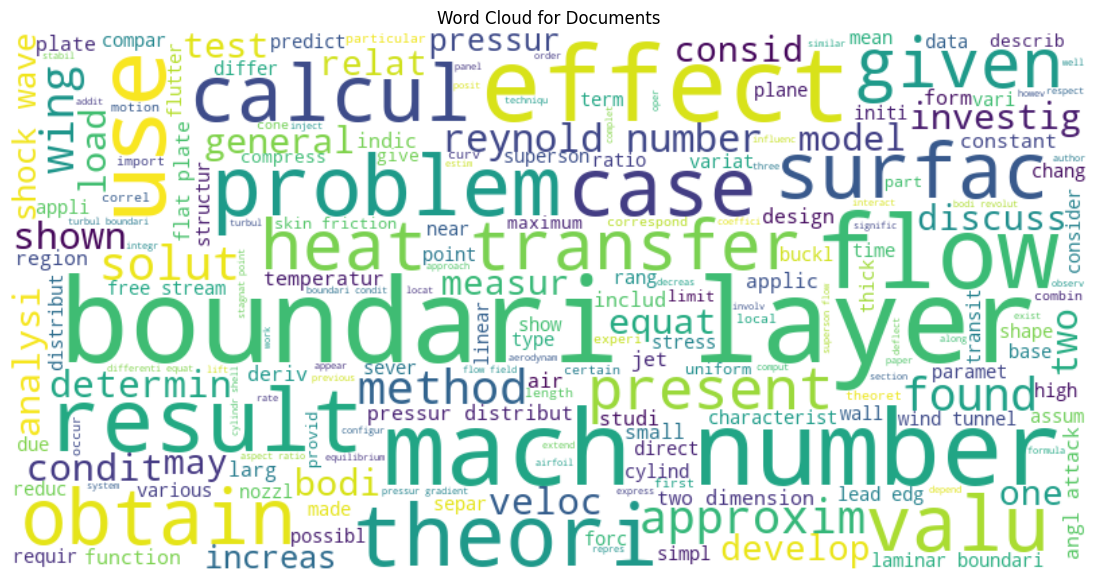

In [10]:
all_words = ' '.join([' '.join(doc) for doc in processed_docs])

wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=None).generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Documents')
plt.show()

## IV. Vector Space Model (VSM) Implement

### Documents indexing

#### Create Inverted Index
    Term frequency (TF_t) is defined by: the number of time term t appear in doc_id
    Inverted index
        Term -> {doc_id : TF_t}
    

In [11]:
inverted_index = create_inverted_index(processed_docs)

print("\n📇 Inverted Index:")

for term, posting in inverted_index.items():
    print(f"{term}: {dict(posting)}")


📇 Inverted Index:
experiment: {1: 2, 11: 1, 12: 1, 16: 1, 17: 1, 19: 1, 25: 1, 29: 1, 30: 2, 35: 1, 37: 1, 41: 1, 42: 1, 43: 1, 47: 1, 52: 1, 53: 1, 58: 1, 69: 1, 70: 1, 74: 1, 78: 2, 84: 2, 99: 2, 101: 1, 103: 1, 112: 1, 115: 1, 121: 1, 123: 3, 131: 1, 137: 1, 140: 1, 142: 1, 154: 1, 156: 1, 167: 1, 168: 1, 170: 1, 171: 2, 173: 2, 176: 1, 179: 2, 183: 1, 184: 1, 186: 3, 187: 1, 188: 1, 189: 1, 191: 1, 195: 3, 197: 2, 202: 1, 203: 1, 206: 2, 207: 2, 212: 1, 216: 1, 220: 1, 222: 1, 225: 2, 227: 1, 230: 1, 234: 4, 245: 1, 251: 1, 256: 2, 257: 1, 262: 1, 271: 2, 273: 1, 277: 1, 282: 1, 283: 1, 286: 1, 287: 1, 289: 1, 294: 1, 295: 1, 304: 1, 307: 1, 329: 2, 330: 2, 334: 2, 338: 1, 339: 1, 344: 2, 345: 1, 346: 3, 347: 1, 354: 1, 360: 1, 369: 1, 370: 1, 372: 2, 377: 1, 397: 1, 409: 1, 411: 2, 413: 2, 418: 1, 420: 1, 421: 1, 423: 1, 427: 1, 433: 1, 435: 1, 439: 1, 441: 2, 442: 3, 443: 1, 453: 1, 455: 2, 462: 1, 464: 1, 467: 1, 484: 3, 494: 2, 496: 1, 497: 1, 498: 1, 501: 1, 503: 1, 504: 1, 5

#### Calculate idf score

    Define IDF Score: Log_10(N/n_t)
    Where N is total number of document
    n_t is total number of document that containing term "t"

In [12]:
def print_idf_vector_pandas(idf_vector):
    df = pd.DataFrame(list(idf_vector.items()), columns=["Term", "IDF"])
    df.index.name = "Index"
    print("📐 IDF Vector Score:")
    print(df.to_string(index=True, justify='center', col_space=12, float_format="%.4f"))

idf_vector = compute_idf_vector(vocab_lst, inverted_index, len(processed_docs))
print_idf_vector_pandas(idf_vector)

📐 IDF Vector Score:
                     Term              IDF    
Index                                         
0                        000degre    3.1461   
1                      000degreek    2.8451   
2                            000k    3.1461   
3                          0degre    2.3010   
4                        100degre    3.1461   
5                          100x10    3.1461   
6                         10degre    2.4472   
7                             10g    3.1461   
8                           1103a    3.1461   
9                            11in    2.8451   
10                        12degre    3.1461   
11                    1400degreek    3.1461   
12                           14in    3.1461   
13                          14x10    3.1461   
14                        15degre    2.6690   
15                          15x10    3.1461   
16                         15x106    3.1461   
17                       180degre    3.1461   
18                        18degre    3.1

#### Index Archiving with Weights
    Since the weights is defined by: TF*IDF
    Our Index become: Term -> {doc_id: weight}

    We need to sort the index hence we could search for term easier

In [13]:
def compute_tfidf_index(index, idf):
    for term, postings in index.items():
        for doc_id, tf in postings.items():
                index[term][doc_id] = tf * idf[term]
    return index


In [14]:
tfidf_index = compute_tfidf_index(inverted_index, idf_vector)
tfidf_index = OrderedDict(sorted(tfidf_index.items()))

In [15]:
for term, posting in tfidf_index.items():
    print(f"{term}: {dict(posting)}")

000degre: {302: 3.146128035678238}
000degreek: {572: 5.690196080028514, 1274: 2.845098040014257}
000k: {1314: 3.146128035678238}
0degre: {688: 2.3010299956639813, 713: 2.3010299956639813, 782: 2.3010299956639813, 972: 2.3010299956639813, 1075: 2.3010299956639813, 1077: 6.903089986991944, 1341: 2.3010299956639813}
100degre: {711: 3.146128035678238}
100x10: {413: 3.146128035678238}
10degre: {351: 2.4471580313422194, 713: 4.894316062684439, 717: 2.4471580313422194, 1001: 4.894316062684439, 1075: 2.4471580313422194}
10g: {1344: 3.146128035678238}
1103a: {738: 3.146128035678238}
11in: {1353: 2.845098040014257, 1354: 2.845098040014257}
12degre: {717: 3.146128035678238}
1400degreek: {1318: 3.146128035678238}
14in: {795: 3.146128035678238}
14x10: {689: 3.146128035678238}
15degre: {688: 2.6690067809585756, 708: 2.6690067809585756, 1104: 5.338013561917151}
15x10: {79: 3.146128035678238}
15x106: {993: 3.146128035678238}
180degre: {993: 3.146128035678238}
18degre: {1001: 3.146128035678238}
18in: {

#### Normalize tfidf_index

In [16]:
def normalize_tfidf_index(tfidf_index, num_docs):
    doc_vectors = [[] for _ in range(num_docs + 1)]  
    terms = sorted(tfidf_index.keys())

    for term in terms:
        for doc_id in range(1, num_docs + 1):
            value = tfidf_index[term].get(doc_id, 0)
            doc_vectors[doc_id].append(value)

    norms = [0] + [math.sqrt(sum(val**2 for val in vec)) for vec in doc_vectors[1:]]

    norm_tfidf_index = OrderedDict()
    for term in terms:
        norm_tfidf_index[term] = {}
        for doc_id in range(1, num_docs + 1):
            val = tfidf_index[term].get(doc_id, 0)
            norm_val = val / norms[doc_id] if norms[doc_id] != 0 else 0
            norm_tfidf_index[term][doc_id] = norm_val

    return norm_tfidf_index


In [17]:
norm_tfidf_index = normalize_tfidf_index(tfidf_index, len(processed_docs))

In [18]:
from itertools import islice

for term, posting in islice(norm_tfidf_index.items(), 50):  # first 200 terms
    limited_posting = dict(islice(posting.items(), 50))      # first 50 docs
    print(f"{term}: {limited_posting}")

000degre: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0}
000degreek: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0}
000k: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.

### Query Processing


In [19]:
def preprocess_query(query):
    return preprocess_text(query)

In [20]:
def query_tfidf_dict(query_terms, idf_dict):
    tf_counter = Counter(query_terms)
    
    tfidf = {
        term: tf_counter[term] * idf_dict.get(term, 0)
        for term in tf_counter
    }

    vec = np.array(list(tfidf.values()))
    vec_norm = norm(vec)

    if vec_norm > 0:
        tfidf = {term: weight / vec_norm for term, weight in tfidf.items()}

    return tfidf

### Matching Query with Document

    Since both query and document are normalized, then our Cosine Similarity Formula turn out without denominator

In [21]:
def cosine_similarity_score(query, norm_tfidf_index, idf_vector):
    query_terms = preprocess_query(query)
    query_tfidf = query_tfidf_dict(query_terms, idf_vector)

    scores = {}
    for term, weight in query_tfidf.items():
        if term in norm_tfidf_index:
            for doc_id, doc_weight in norm_tfidf_index[term].items():
                scores[doc_id] = scores.get(doc_id, 0) + weight * doc_weight


    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores


###

In [22]:
def retrieve_all_queries(list_of_queries, norm_tfidf_index, idf_vector):
    results = {}

    for qid, query in enumerate(list_of_queries, start=1):  
        scores = cosine_similarity_score(query, norm_tfidf_index, idf_vector)

        ranked_docs = [doc_id for doc_id, score in scores if score > 0]

        results[qid] = ranked_docs

    return results


In [23]:
retrieval_results = retrieve_all_queries(queries, norm_tfidf_index, idf_vector)

#### Plot Metric Score


Average Precision: 0.0096
Average Recall: 0.9621


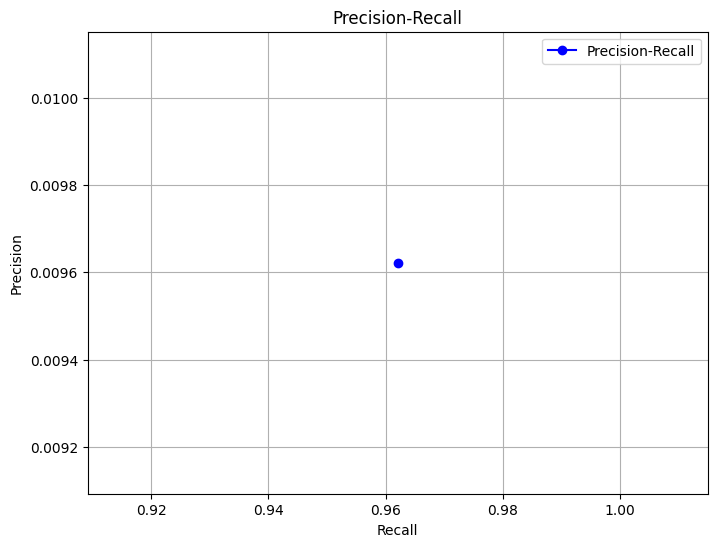

In [24]:
precision, recall = evaluate_precision_recall(retrieval_results, relevance)

plot_precision_recall(precision, recall)

c:\Users\gryffin\miniconda3\envs\IR\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


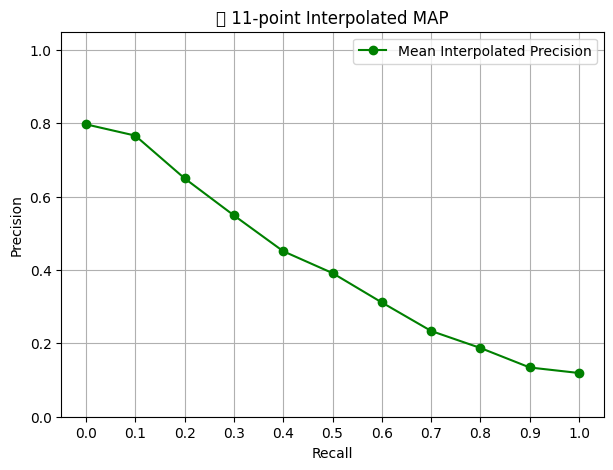

 MAP nội suy 11 điểm: 0.4175


In [25]:
avg_precisions_vector = compute_interpolated_precisions(retrieval_results, relevance)
plot_interpolated_map(avg_precisions_vector)

## V. LSI with boolean combined

### Latent Semantic Indexing
    Since we have inverted index with tf-idf weighted, created above, then we can create term-document matrix with tf-idf weighted respectively. Hence we will have our Matrix with shape (number of term x number of doc)

#### Create Term-document matrix

In [26]:
terms = list(norm_tfidf_index.keys())
num_docs = len(processed_docs)

term_doc_matrix = np.zeros((len(terms), num_docs))

for i, term in enumerate(terms):
    for doc_id in range(1, num_docs + 1):
        term_doc_matrix[i, doc_id - 1] = norm_tfidf_index[term].get(doc_id, 0)


In [27]:
print(term_doc_matrix.shape)

(4226, 1400)


#### Apply Truncated SVD on Term-document matrix

In [28]:
def find_optimal_k_from_s(singular_values, energy_threshold=0.9):
    """
        Find the optimal number of dimensions (k) based on the cumulative energy of singular values.
    """
    squared_sv = singular_values ** 2
    total_energy = np.sum(squared_sv)
    cumulative_energy = np.cumsum(squared_sv)

    for k, energy in enumerate(cumulative_energy):
        if energy / total_energy >= energy_threshold:
            return k + 1
    return len(singular_values)

In [29]:
def apply_svd_with_flex_k(term_doc_matrix, user_defined_k=None, energy_threshold=0.9, verbose=True):
    """
    Apply SVD on term-document matrix. 
    Let:
    - User select k (user_defined_k), or
    - find k automatically base on thresh hold if user_defined_k=None

    Return: U_k, Sigma_k, Vt_k, k_used
    """
    U, s, Vt = np.linalg.svd(term_doc_matrix, full_matrices=False)

    if user_defined_k is None:
        k = find_optimal_k_from_s(s, energy_threshold)
        if verbose:
            print(f"[Auto-K] Keep {energy_threshold*100:.0f}% cumulative energy → k = {k}")
    else:
        k = user_defined_k
        if verbose:
            print(f"[Manual-K] Use k = {k} defined by user")

    U_k = U[:, :k]
    Sigma_k = np.diag(s[:k])
    Vt_k = Vt[:k, :]

    if verbose:
        print(f"\n--- SVD Component Shapes (Truncated) ---")
        print(f"U_k: {U_k.shape}, Sigma_k: {Sigma_k.shape}, Vt_k: {Vt_k.shape}")
        print("-" * 40)

    return U_k, Sigma_k, Vt_k, k

In [30]:
U_k, Sigma_k, Vt_k, k_used = apply_svd_with_flex_k(term_doc_matrix, user_defined_k=None, energy_threshold=0.9)

[Auto-K] Keep 90% cumulative energy → k = 747

--- SVD Component Shapes (Truncated) ---
U_k: (4226, 747), Sigma_k: (747, 747), Vt_k: (747, 1400)
----------------------------------------


#### Create Index

In [31]:
doc_ids = [f"{i+1}" for i in range(len(documents))]

def LatentSemanticIndexing(U_k, Sigma_k, Vt_k, doc_ids):
    """
    Perform Latent Semantic Indexing (LSI) using SVD components.
    Returns the L2-normalized LSI representation of documents.
    """
    V_k_dense = Vt_k.T                      # (N_documents x k)
    doc_vectors_lsi = V_k_dense @ Sigma_k  # Shape: (N x k)

    doc_vectors_lsi_normalized = normalize(doc_vectors_lsi, axis=1) 

    # Build dict {doc_id: normalized_vector}
    document_latent_vectors = {
        doc_id: doc_vectors_lsi_normalized[i] for i, doc_id in enumerate(doc_ids)
    }

    return document_latent_vectors


### Query processing

Since we already had `idf_vector` created above, just process the query like in VSM.  
But with the LSI model, we must transform it into lower-dimensional space:  
To transform a query vector into the LSI (latent semantic indexing) space, we use the reduced SVD matrices from above.

The query vector $\mathbf{q}$ is first constructed in the original term space, then projected into the lower-dimensional LSI space using:

$\mathbf{q}_{\text{transformed}} = \Sigma_k^{-1} \cdot U_k^T \cdot \mathbf{q}$

where $U_k$ and $\Sigma_k$ are from the truncated SVD of the term-document matrix.

In [32]:
def process_query_lsi(raw_query, idf_vector, U_k, Sigma_k):
    processed_query = preprocess_text(raw_query)
    query_tfidf = query_tfidf_dict(processed_query, idf_vector)


    processed_query = preprocess_text(raw_query)
    query_tfidf = query_tfidf_dict(processed_query, idf_vector)

    # Convert query_tfidf dict to dense vector in vocab order
    vocab = list(idf_vector.keys())
    query_tfidf_dense = np.array([query_tfidf.get(term, 0) for term in vocab])

    Sigma_k_inv = np.linalg.inv(Sigma_k) 
    query_latent_vector = query_tfidf_dense @ U_k @ Sigma_k_inv

    query_latent_vector = query_latent_vector.reshape(1, -1)  
    query_latent_vector = normalize(query_latent_vector, axis=1)  
    return query_latent_vector



### Matching Query with Document
    We would combine a Boolean layer into LSI model

In [33]:
def LSI_with_boolean(queries, document_latent_vectors, idf_vector, U_k, Sigma_k):
    results = {}

    for qid, query in enumerate(queries, start=1):
        candidate_docs = boolean_retrieval(query, inverted_index)  
        query_latent_vector = process_query_lsi(query, idf_vector, U_k, Sigma_k)
        
        scores = {}
        for doc_id in candidate_docs:
            doc_id_str = str(doc_id)  # Ensure key is a string
            if doc_id_str in document_latent_vectors:
                score = query_latent_vector @ document_latent_vectors[doc_id_str].T
                if score > 0:
                    scores[doc_id] = score

        ranked_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        results[qid] = [doc_id for doc_id, _ in ranked_docs]

    return results

In [34]:
retrieval_results_lsi = LSI_with_boolean(queries, LatentSemanticIndexing(U_k, Sigma_k, Vt_k, doc_ids), idf_vector, U_k, Sigma_k)

#### Plot Metric Score


Average Precision: 0.0135
Average Recall: 0.8653


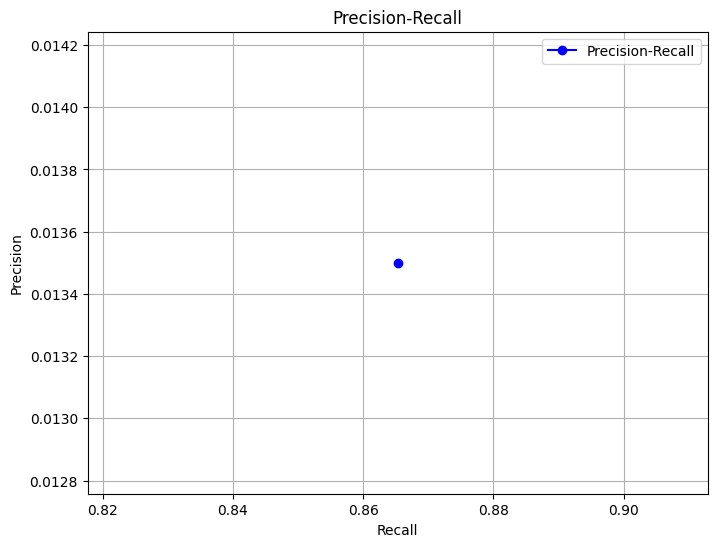

In [35]:
precision_1, recall_1 = evaluate_precision_recall(retrieval_results_lsi, relevance)

plot_precision_recall(precision_1, recall_1)

c:\Users\gryffin\miniconda3\envs\IR\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


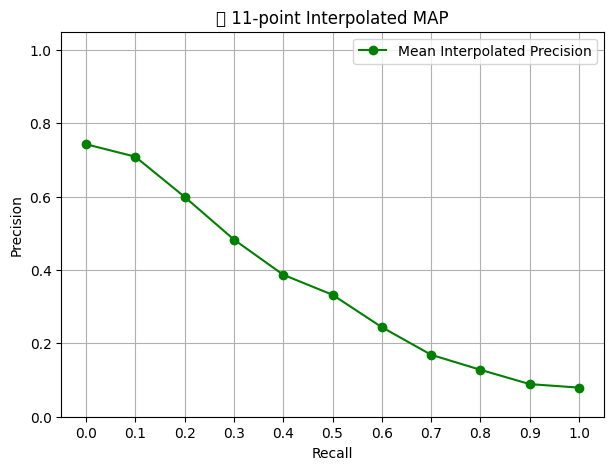

 MAP nội suy 11 điểm: 0.3604


In [36]:
avg_precisions_LSI = compute_interpolated_precisions(retrieval_results_lsi, relevance)
plot_interpolated_map(avg_precisions_LSI)

#### Evaluate LSI model with k - demension

In [37]:
k_values = list(range(10, 201, 10))  
map_scores = []


In [38]:
def analyze_map_vs_k_lsi_boolean(
    queries,
    term_doc_matrix,
    idf_vector,
    inverted_index,
    relevance_dict,
    k_list,
    doc_ids
):
    map_scores = []

    for k in k_list:

        U_k, Sigma_k, Vt_k, _ = apply_svd_with_flex_k(term_doc_matrix, user_defined_k=k,verbose=False)

        document_latent_vectors = LatentSemanticIndexing(U_k, Sigma_k, Vt_k, doc_ids)

        retrieved_docs_dict = LSI_with_boolean(
            queries, document_latent_vectors, idf_vector, U_k, Sigma_k
        )

        map_11pt = compute_interpolated_precisions(retrieved_docs_dict, relevance_dict)
        # FIX: Take mean if dict
        if isinstance(map_11pt, dict):
            mean_map = np.mean(list(map_11pt.values()))
        else:
            mean_map = map_11pt
        map_scores.append(mean_map)

    plt.figure(figsize=(8, 5))
    plt.plot(k_list, map_scores, marker='o', color='blue')
    plt.title("MAP (11-point interpolated) vs.  k - dimension in LSI")
    plt.xlabel("k - dimension")
    plt.ylabel("MAP interpolated")
    plt.grid(True)
    plt.xticks(k_list)
    plt.show()

    return None

In [ ]:
analyze_map_vs_k_lsi_boolean( queries,
    term_doc_matrix,
    idf_vector,
    inverted_index,
    relevance,
    k_list=k_values
    , doc_ids=doc_ids)
   